In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
import sys
sys.path.append('..')
from fdfdpy.simulation import Simulation
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 1
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# define the two port parameters
L = 5
H = 5
w = .2
d = 2.6
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 3

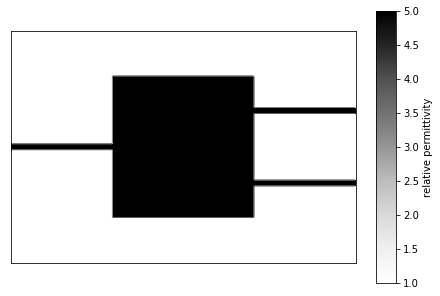

(305, 205)


In [7]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
shape = (Nx,Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)
simulation = Simulation(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()
print(eps_r.shape)

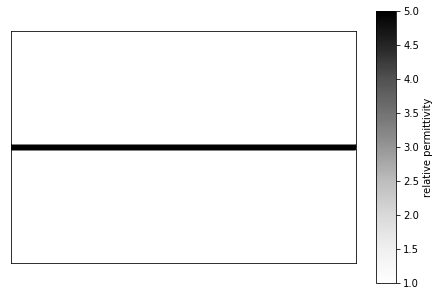

waveguide has 5 points in in port


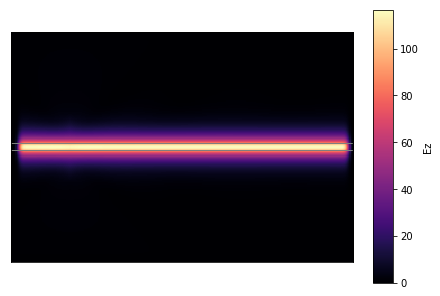

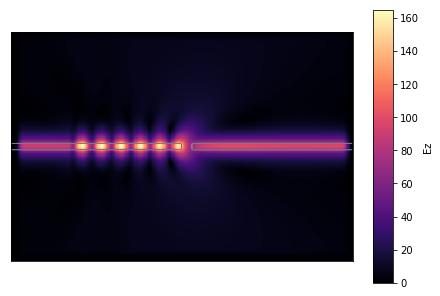

In [5]:
eps_wg = np.ones(eps_r.shape)
eps_wg[:, ny-2:ny+3] = eps_m
simulation_wg = Simulation(omega,eps_wg,dl,NPML,pol)
simulation_wg.plt_eps()
plt.show()
pts_in = np.sum(eps_wg[NPML[0]+3,:] > 1)
print('waveguide has {} points in in port'.format(pts_in))
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=70)
simulation_wg.setup_modes()
(Hx,Hy,Ez) = simulation_wg.solve_fields()
simulation_wg.plt_abs(outline=True, cbar=True);
eps_wg[nx:nx+10, :] = 1
simulation_wg.eps_r = eps_wg
(Hx,Hy,Ez) = simulation_wg.solve_fields()
simulation_wg.plt_abs(outline=True, cbar=True);

In [8]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
nl_region = np.array(eps_r > 1).astype(int)
nl_region[:nx-int(L/2/dl),:] = 0
nl_region[nx+int(L/2/dl):,:] = 0

# simulation to solve
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 10.136646963673254 W/L0


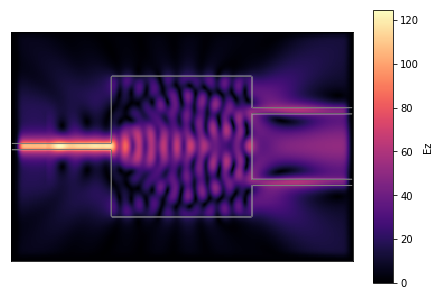

In [9]:
# plot linear field
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

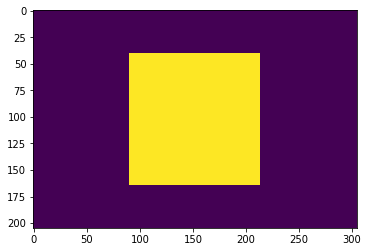

In [20]:
design_region = nl_region
plt.imshow(design_region.T)
plt.show()

# Re-initialize the simulation
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region)

# define linear and nonlinear parts of objective function + the total objective function form
J_cent = np.zeros(eps_r.shape)
J_cent[nx, ny] = 1
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_cent)

# define the derivatives
dJ = {}
dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_cent

In [24]:
# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=5000, J=J, dJ=dJ, eps_max=eps_m, step_size=.001, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

1609.834152682277 1601.8044110387564 0.004987930980431448
54.382040216915414 54.378751665353775 6.047127964529079e-05
-1233.959205934667 -1233.9918874204159 2.6485061736077464e-05
-534.476002875992 -535.1946223527193 0.0013445308542581265
-266.98757877773187 -267.0037839561701 6.069637588535071e-05


100% (5000 of 5000) |####################| Elapsed Time: 1:56:46 ETA:  00:00:00

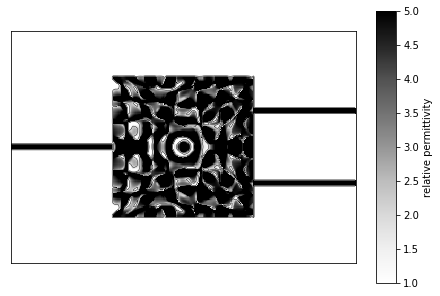

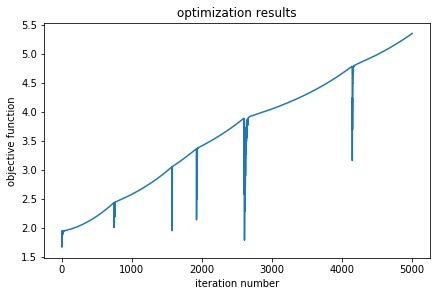

In [25]:
# run that optimization with the simulation and your objective function stuff
(new_eps_1) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs(scaled='E2_in')
plt.show()

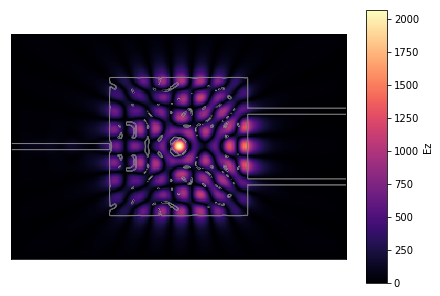

KeyboardInterrupt: 

In [23]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs()
plt.show()

difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [94]:
# Re-initialize the simulation
simulation = Simulation(omega, new_eps_1, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=20)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region)

# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_top)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define the derivatives
dJ = {}
dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_top
dJ['dE_nonlinear'] = lambda e, eps_r: -np.conj(e)*J_top
dJ['total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

In [95]:
# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=70, J=J, dJ=dJ, eps_max=eps_m, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

0.2901850769395846 0.2901791685872013 2.0360634825386752e-05
-0.4402616727008992 -0.44027956391801126 4.063768940476777e-05
-0.13176057598377922 -0.1317628994002007 1.7633623746189324e-05
0.04613638918037474 0.04613614692061674 5.25094751254058e-06
-0.20891081897175678 -0.20891104213660583 1.068230214898021e-06
0.05967617024295935 0.05967687684460543 1.1840599743691443e-05
0.33657758400490534 0.33657874610071303 3.452683312615291e-06
0.1290268340618228 0.12902790331281722 8.287043561030116e-06
0.10277392768265659 0.1027741336656618 2.0042340489716697e-06
0.6907634100077564 0.6907658780619386 3.5729370525123163e-06


100% (70 of 70) |########################| Elapsed Time: 0:05:45 ETA:  00:00:00

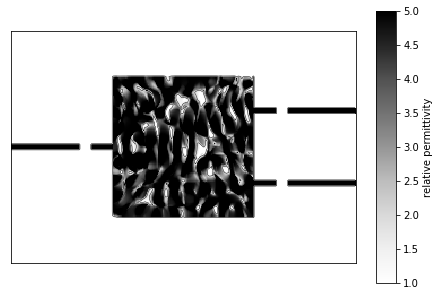

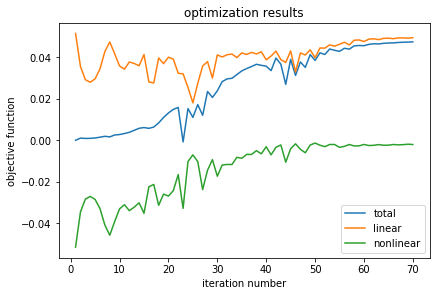

In [96]:
# run that optimization with the simulation and your objective function stuff
(new_eps_2) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs(scaled='E2_in')
plt.show()

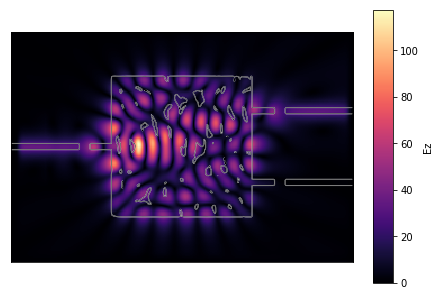

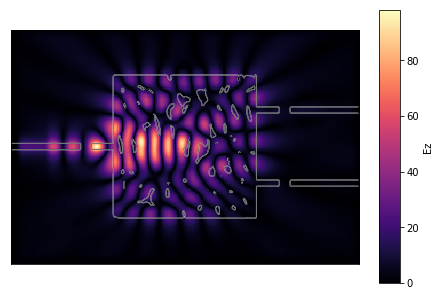

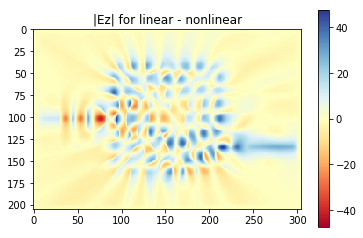

In [97]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs()
plt.show()

difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

maximum refractive index shift of 0.33980374201228275


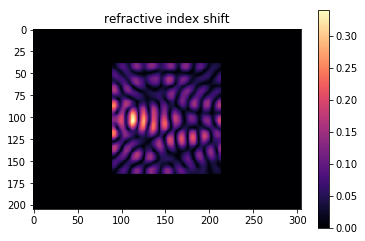

In [101]:
# compute the refractive index shift
index_shift = opt_both.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma')
plt.colorbar()
plt.title('refractive index shift')
plt.show()